# Lista 1

Disciplina: ELE08624 - Tópicos Especiais em Processamento de Imagens

Semestre: 2020/1 - especial

Aluno: Gabriel Carvalho Benedito

Matrícula: 2013100874

## Imports

In [16]:
# imports
import cmath
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import image, colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import PIL
from scipy.fft import fft2, fftshift, ifft2

## Funções personalizadas

In [18]:
# NOTE: all custom function assumes normalized images on range [0, 1]

# plots an grayscale image
def plot_img(img, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# plots input and output images
def plot_img_in_out(img_in, img_out):
    fig, axs = plt.subplots(1, 2)
    # input image
    axs[0].imshow(img_in, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Entrada')
    axs[0].axis('off')
    # output image
    axs[1].imshow(img_out, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Saída')
    axs[1].axis('off')

# plots input and output images
def plot_spectrum(img):
    fig, axs = plt.subplots(1, 3)
    # input image
    axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('Entrada')
    axs[0].axis('off')
    # fft2
    img_fft2_abs, img_fft2_angle = fft2_polar(img)
    # abs
    axs[1].imshow(img_fft2_abs, cmap='gray', norm=LogNorm())
    axs[1].set_title('Módulo')
    axs[1].axis('off')
    # angle
    axs[2].imshow(img_fft2_angle, cmap='gray', vmin=-np.pi, vmax=np.pi)
    axs[2].set_title('Fase')
    axs[2].axis('off')

# plots an frequency and density histogram
def plot_hist(img, n_bins=30):
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Histograma')
    plt.subplots_adjust(wspace=0.39)
    # vetorize image (transform to 1D-vector)
    vect_img = np.reshape(img, (-1))
    # stats
    img_mean = np.mean(vect_img)
    img_median = np.median(vect_img)
    mean_label = 'Média = {:.2f}'.format(img_mean)
    median_label = 'Mediana = {:.2f}'.format(img_median)
    # frequencies
    axs[0].hist(vect_img, bins=n_bins)
    axs[0].axvline(img_mean, c='g', label=mean_label)
    axs[0].axvline(img_median, c='r', label=median_label)
    axs[0].legend(fontsize='xx-small')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylabel('Número de pixels')
    axs[0].set_xlabel('Intensidade [0, 1]')
    # density
    weights = np.ones_like(vect_img) / vect_img.size
    axs[1].hist(vect_img, bins=n_bins, weights=weights)
    axs[1].axvline(img_mean, c='g', label=mean_label)
    axs[1].axvline(img_median, c='r', label=median_label)
    axs[1].legend(fontsize='xx-small')
    axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axs[1].set_xlim(0, 1)
    axs[1].set_ylabel('Densidade')
    axs[1].set_xlabel('Intensidade [0, 1]')

# according to exercice 4 specification
def spatial_conv(a, kernel_func, kernel_size=1, padding=False, mode='constant', **kwargs):
    # neighborhood range of kernel along each axis, considering a central pixel and without conting it
    kernel_offset = int((kernel_size - 1) / 2)
    # compute input
    if not padding:
        # just copy
        a_in = np.copy(a)
    else:
        # pad width
        pad_width = kernel_offset
        # apply padding given numpy possibilities
        a_in = np.pad(a, pad_width, mode, **kwargs)
    # initialize output
    b_out_shape = (a_in.shape[0] - kernel_size + 1, a_in.shape[1] - kernel_size + 1)
    b_out = np.empty(b_out_shape, dtype=a_in.dtype)
    # iterate over rows and coluns
    for r_out, r_in in enumerate(range(kernel_offset, a_in.shape[0] - kernel_offset)):
        for c_out, c_in in enumerate(range(kernel_offset, a_in.shape[1] - kernel_offset)):
            # kernel as neighborhood of input
            kernel = a_in[r_in-kernel_offset:r_in+kernel_offset+1, c_in-kernel_offset:c_in+kernel_offset+1]
            # apply kernel function
            b_out[r_out, c_out] = kernel_func(kernel)
    return b_out

# element-wise polar-rect complex transform
def rect(x_abs, x_angle):
    x = np.empty_like(x_abs).astype(complex)
    for r in range(x_abs.shape[0]):
        for c in range(x_abs.shape[1]):
            x[r, c] = cmath.rect(x_abs[r, c], x_angle[r, c])
    return x

# polar components of dft of x (applies fftshift before returning)
def fft2_polar(x):
    x_fft2 = fftshift(fft2(x))
    return np.abs(x_fft2), np.angle(x_fft2)

# inverse dft of x from polar components (applies fftshift before computing)
def real_ifft2_polar(x_abs, x_angle):
    return np.real(ifft2(fftshift(rect(x_abs, x_angle))))

## Exercício 1

Usando a definição de conectividade de pixels, faça um programa que conte automaticamente o número de palitos de fósforo na imagem [ex_1.jpg](img/ex_1.jpg), informando também a área (número de pixels) de cada um deles. Seu programa deve fornecer a área de cada palito (desconsidere a cabeça dos palitos). Observe que você terá que binarizar a imagem: gere o seu histograma e escolha um valor de limiar para mapear, acima dele, no nível de cinza 255; e abaixo ou igual aele, no nível de cinza 0.

### Imagem de entrada

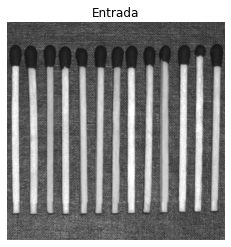

In [3]:
# open image
img = image.imread('img/ex_1.jpg')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Histograma

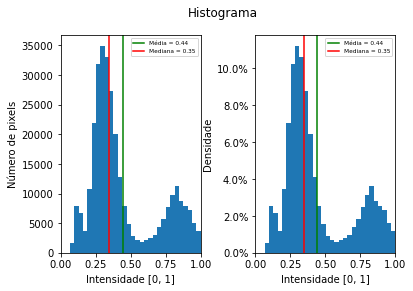

In [4]:
plot_hist(img)

### Filtro de média e mediana 5x5

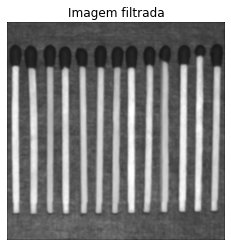

In [5]:
filt_img = spatial_conv(img, lambda x: np.mean(x), kernel_size=5, padding=True)
filt_img = spatial_conv(filt_img, lambda x: np.median(x), kernel_size=5, padding=True)
plot_img(filt_img, 'Imagem filtrada')

### Binarização

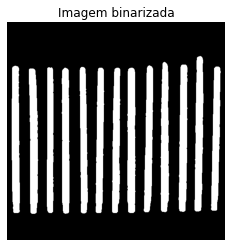

In [6]:
img_bin = np.vectorize(lambda x: 1. if x > .5 else 0.)(filt_img)
plot_img(img_bin, 'Imagem binarizada')

### Método para obter região conectada

In [25]:
def get_connected_component(x, r, c):
    connected_component = set()
    next_level = {(r, c)}
    while next_level:
        this_level = next_level
        next_level = set()
        for pixel in this_level:
            if pixel not in connected_component:
                connected_component.add(pixel)
                mask_r_start = pixel[0] - 1 if pixel[0] - 1 >= 0 else 0
                mask_r_stop = pixel[0] + 2 if pixel[0] + 2 <= x.shape[0] else x.shape[0]
                mask_c_start = pixel[1] - 1 if pixel[1] - 1 >= 0 else 0
                mask_c_stop = pixel[1] + 2 if pixel[1] + 2 <= x.shape[1] else x.shape[1]
                for mask_r in range(mask_r_start, mask_r_stop):
                    for mask_c in range(mask_c_start, mask_c_stop):
                        if x[mask_r, mask_c] == x[r, c]:
                            next_level.add((mask_r, mask_c))
    return connected_component

### Plota imagem binarizada e imagem de palitos detectados com suas respectivas áreas

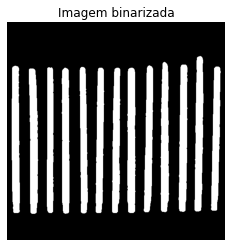

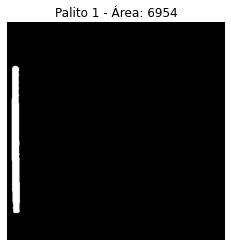

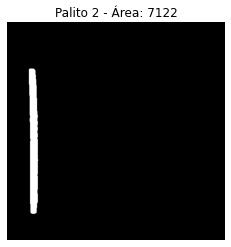

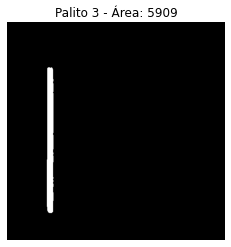

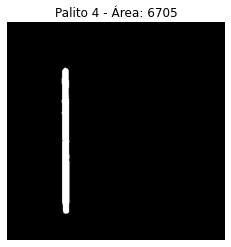

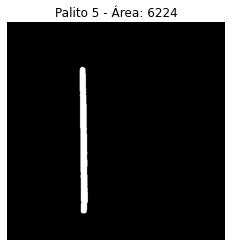

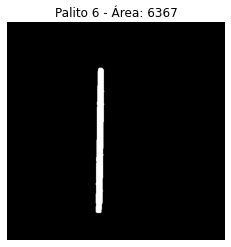

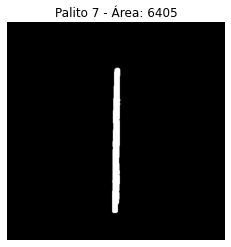

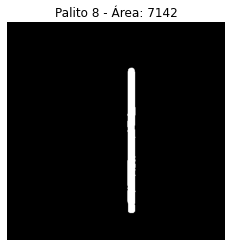

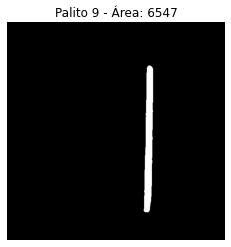

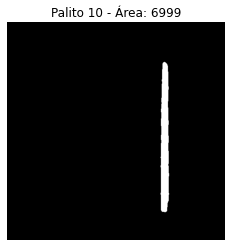

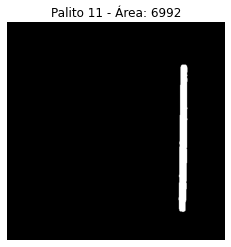

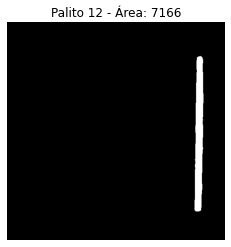

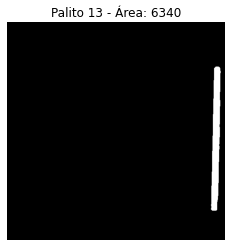

In [27]:
targets = []
img_tmp = np.copy(img_bin)
for c in range(img_tmp.shape[1]):
    for r in range(img_tmp.shape[0]):
        if img_tmp[r, c] == 1:
            target = np.zeros_like(img_tmp)
            connected_component = get_connected_component(img_tmp, r, c)
            for target_r, target_c in connected_component:
                target[target_r, target_c] = 1
            targets.append(target)
            img_tmp[target.astype(bool)] = 0

# plot targets
plot_img(img_bin, 'Imagem binarizada')
for i, target in enumerate(targets):
    plot_img(target, 'Palito {} - Área: {}'.format(i + 1, int(np.sum(target))))

## Exercício 2

Use a técnica de fatiamento de níveis de intensidade para realçar a aorta da figura [ex_2.jpg](img/ex_2.jpg).

### Imagem de entrada

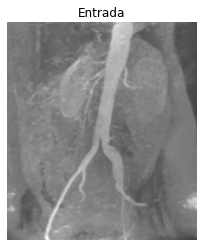

In [32]:
# open image
img = image.imread('img/ex_2.jpg')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Histograma

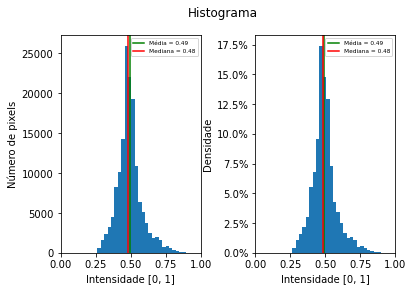

In [33]:
plot_hist(img)

### Fatiamento de níveis de intensidade 

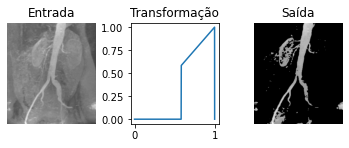

In [34]:
# itensity transform
y = lambda x, min_val, max_val: x if (x > min_val and x < max_val) else 0.
y = np.vectorize(y)

# transform arguments
min_val = .582
max_val = 1.

# apply transform
out_img = y(img, min_val, max_val)

# plots
fig, axs = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4)
# input image
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Entrada')
axs[0].axis('off')
# itensity transform graph
x = np.linspace(0., 1., num=1000)
axs[1].plot(x, y(x, min_val, max_val))
axs[1].set_title('Transformação')
axs[1].set_aspect(img.shape[0]/img.shape[1])
# output image
axs[2].imshow(out_img, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Saída')
axs[2].axis('off');

## Exercício 3

Implemente: a) uma função que realiza a equalização de histograma, b) uma função para obter uma imagem de saída cujo histograma seja da forma mostrada na figura abaixo. Aplique ambas as funções sobre as figuras [ex_3_0.jpg](img/ex_3_0.jpg) e [ex_3_1.jpg](img/ex_3_1.jpg). Discuta os resultados avaliando os histogramas. Calcule a média amostral e a variância amostral das imagens, antes e após a aplicação das funções. Mostre, para cada caso, o histograma antes e depois da aplicação do método. É possível relacionar os resultados com as imagens? Explique.

![alt text](img/ex_3_p.png)

### Imagem de entrada

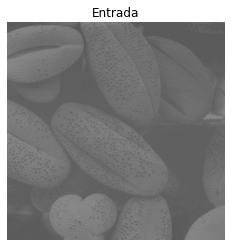

In [4]:
# open image
img = image.imread('img/ex_3_0.jpg')

# plot
plot_img(img/255, 'Entrada')

### Histograma (imagem normalizada)

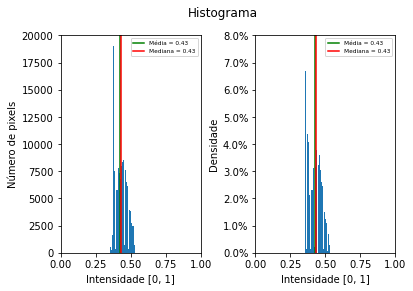

In [11]:
plot_hist(img/255, n_bins=50)

### Métodos relacionados à equalização de histograma

In [24]:
# consider images as matrices holding uint8 values

# returns PDF as a 256-sized vector
def get_pdf_vect(img):
    x = np.arange(0, 256)
    pdf = np.empty_like(x)
    vect_img = np.reshape(img, (-1))
    for v in x:
        pdf[v] = np.sum(np.where(img == v, 1, 0))
    return pdf / img.size

# returns the histogram equalized image
def equalize(img):
    pdf_vect = get_pdf_vect(img)
    eq_func = lambda x: (255*np.sum(pdf_vect[0:x+1])).astype(np.uint8)
    eq_func = np.vectorize(eq_func)
    return eq_func(img)


### Equalização

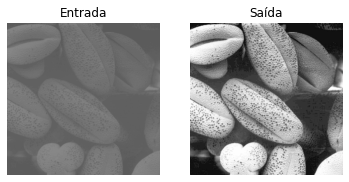

In [25]:
eq_img = equalize(img)
plot_img_in_out(img/255, eq_img/255)

### Histograma obtido

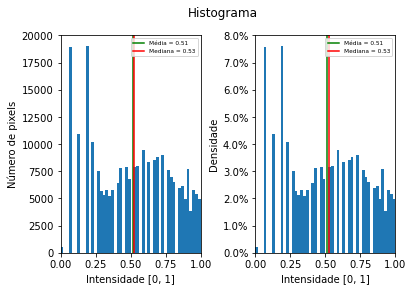

In [26]:
plot_hist(eq_img/255, n_bins=50)

In [43]:
# returns an image based on specified hist (PDF)
def specify_hist(img, pdf_vect):
    eq_img = equalize(img)
    tranform = lambda x: np.floor(255*np.sum(pdf_vect[0:x+1])).astype(np.uint8)
    tranform = np.vectorize(tranform)
    return tranform(eq_img)

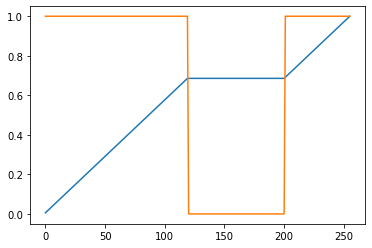

In [44]:
x = np.arange(256)
y = np.empty_like(x).astype(float)
for i in x:
    y[i] = np.sum(pdf_vect[0:i+1])

plt.plot(x, y)
plt.plot(x, pdf_vect/np.max(pdf_vect))

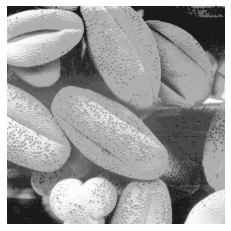

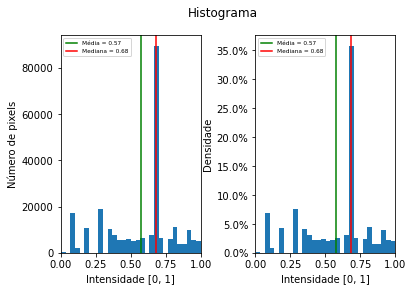

In [46]:
pdf_vect = np.ones((256,), dtype=float)
pdf_vect = pdf_vect/(255-(200-120))
pdf_vect[120:201] = 0
out_img = specify_hist(img, pdf_vect)
plot_img(out_img/255)
plot_hist(out_img/255)

## Exercício 4

Faça uma rotina que implemente uma máscara de convolução espacial de dimensão NxN (N ímpar). Discuta as soluções de tratamento de bordas. Depois, teste as rotinas implementadas na imagem [ex_4.tif](img/ex_4.tif), para os seguintes casos: a) filtro passa-baixas, b) filtro laplaciano, c) filtro de Sobel. Exiba os resultados e comente-os.

#### Considerações sobre a convolução matriz-matriz:

Seja `X` uma matriz `A x B` e `Y` uma matriz `C x D`, expressamos a convolução matriz-matriz `X * Y` por:

- `Z = X * Y`

on `Z` é uma matriz `E x F` cujas dimensões são dadas por:

- `E = A - C + 1`
- `F = B - D + 1`

### Rotina de aplicação de máscara de convolução espacial

In [35]:
def spatial_conv(a, kernel_func, kernel_size=1, padding=False, mode='constant', **kwargs):
    # neighborhood range of kernel along each axis, considering a central pixel and without conting it
    kernel_offset = int((kernel_size - 1) / 2)
    # compute input
    if not padding:
        # just copy
        a_in = np.copy(a)
    else:
        # pad width
        pad_width = kernel_offset
        # apply padding given numpy possibilities
        a_in = np.pad(a, pad_width, mode, **kwargs)
    # initialize output
    b_out_shape = (a_in.shape[0] - kernel_size + 1, a_in.shape[1] - kernel_size + 1)
    b_out = np.empty(b_out_shape, dtype=a_in.dtype)
    # iterate over rows and coluns
    for r_out, r_in in enumerate(range(kernel_offset, a_in.shape[0] - kernel_offset)):
        for c_out, c_in in enumerate(range(kernel_offset, a_in.shape[1] - kernel_offset)):
            # kernel as neighborhood of input
            kernel = a_in[r_in-kernel_offset:r_in+kernel_offset+1, c_in-kernel_offset:c_in+kernel_offset+1]
            # apply kernel function
            b_out[r_out, c_out] = kernel_func(kernel)
    return b_out

### Imagem de entrada

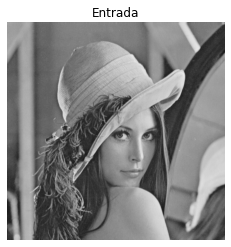

In [36]:
# open image
img = image.imread('img/ex_4.tif')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Soluções de tratamento de bordas

TODO

### Filtro passa-baixas

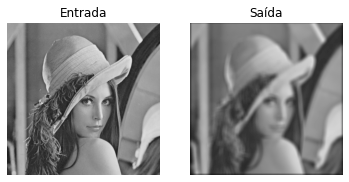

In [37]:
# mean filter on a 15x15 kernel, padding input input and filling it with zeroes
img_out = spatial_conv(img, lambda x: np.mean(x), kernel_size=15, padding=True)

# plots
plot_img_in_out(img, img_out)

### Filtro laplaciano

In [38]:
# isotropic laplacian filter
def ilf90(x):
    i = int((x.shape[0]-1)/2)
    return  4*x[i, i] - (x[i+1, i] + x[i-1, i] + x[i, i+1] + x[i, i-1])
def ilf45(x):
    i = int((x.shape[0]-1)/2)
    return 9*x[i, i] - np.sum(x)


#### Isotrópico para rotações de 90º

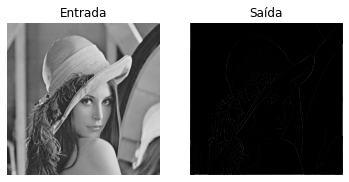

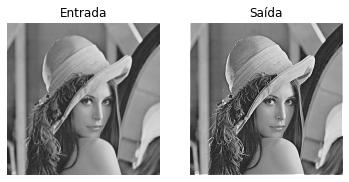

In [39]:
# isotropic laplacian filter (90º-isotropic), padding input input and filling it with zeroes
img_out = spatial_conv(img, ilf90, kernel_size=3, padding=True)
# plots
plot_img_in_out(img, img_out)
plot_img_in_out(img, img + img_out)

#### Isotrópico para rotações de 45º

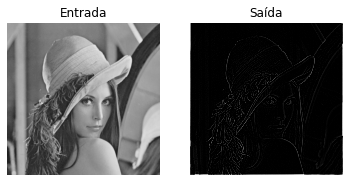

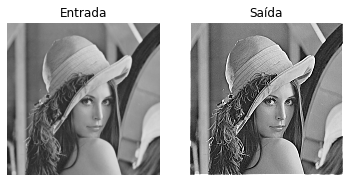

In [40]:
# isotropic laplacian filter (45º-isotropic), padding input input and filling it with zeroes
img_out = spatial_conv(img, ilf45, kernel_size=3, padding=True)
# plots
plot_img_in_out(img, img_out)
plot_img_in_out(img, img + img_out)

### Filtro de Sobel

In [41]:
# sobel operators
sobel_op_1 = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]], dtype=img.dtype)
sobel_op_2 = np.rot90(sobel_op_1)
sobel_op_3 = np.array([[ 0,  1,  2],
                       [-1,  0,  1],
                       [-2, -1,  0]], dtype=img.dtype)
sobel_op_4 = np.rot90(sobel_op_3, 3)

def sobel(op=1):
    if op == 1:
        return lambda x: np.sum(sobel_op_1 * x)
    elif op == 2:
        return lambda x: np.sum(sobel_op_2 * x)
    elif op == 3:
        return lambda x: np.sum(sobel_op_3 * x)
    else:
        return lambda x: np.sum(sobel_op_4 * x)

#### Operador 1

In [42]:
print(sobel_op_1)

[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]


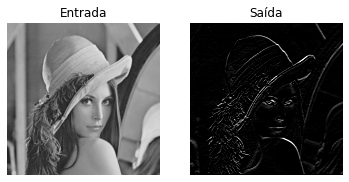

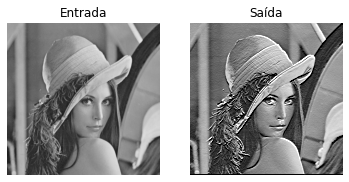

In [43]:
# sobel operator 1, padding input input and filling it with zeroes
img_out = spatial_conv(img, sobel(1), kernel_size=3, padding=True)
# plots
plot_img_in_out(img, img_out)
plot_img_in_out(img, img + img_out)

#### Operador 2

In [44]:
print(sobel_op_2)

[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]


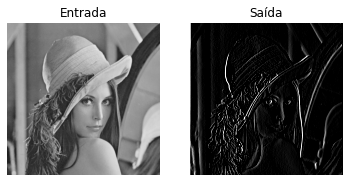

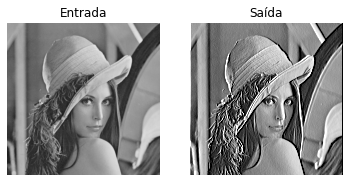

In [45]:
# sobel operator 1, padding input input and filling it with zeroes
img_out = spatial_conv(img, sobel(2), kernel_size=3, padding=True)
# plots
plot_img_in_out(img, img_out)
plot_img_in_out(img, img + img_out)

#### Operador 3

In [46]:
print(sobel_op_3)

[[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]


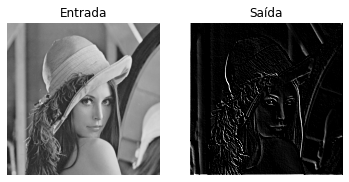

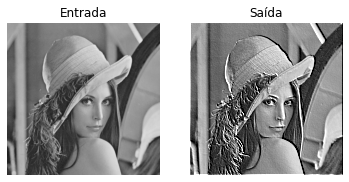

In [47]:
# sobel operator 1, padding input input and filling it with zeroes
img_out = spatial_conv(img, sobel(3), kernel_size=3, padding=True)
# plots
plot_img_in_out(img, img_out)
plot_img_in_out(img, img + img_out)

#### Operador 4

In [48]:
print(sobel_op_4)

[[-2. -1.  0.]
 [-1.  0.  1.]
 [ 0.  1.  2.]]


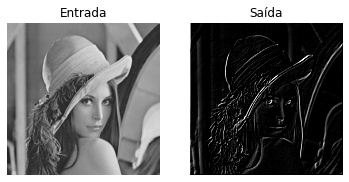

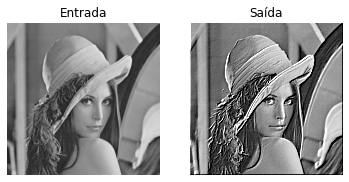

In [49]:
# sobel operator 1, padding input input and filling it with zeroes
img_out = spatial_conv(img, sobel(4), kernel_size=3, padding=True)
# plots
plot_img_in_out(img, img_out)
plot_img_in_out(img, img + img_out)

## Exercício 5

Reduza a imagem [ex_5.png](img/ex_5.png) eliminando alternadamente as linhas e colunas. Compare a imagem original com a reduzida. O que aconteceu com ela? Ela possui a mesma aparência? Por que isso aconteceu? Que procedimento você poderia aplicar para reduzir esse efeito? Aplique a solução imaginada para evitar esse efeito na imagem reduzida. Compare a nova imagem com as outras duas e avalie o resultado.

### Imagem de entrada

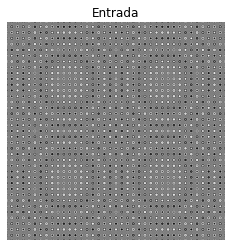

In [4]:
# open image
img = image.imread('img/ex_5.png')

# plot
plot_img(img, 'Entrada')

### Redução

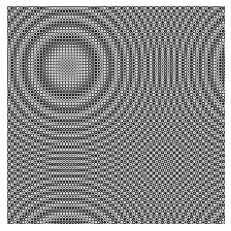

In [5]:
img_out = np.empty((int(img.shape[0]/2), int(img.shape[1]/2)))

for r in range(img_out.shape[0]):
    for c in range(img_out.shape[1]):
        img_out[r, c] = img[int(2*r), int(2*c)]

plot_img(img_out)

### Comparação

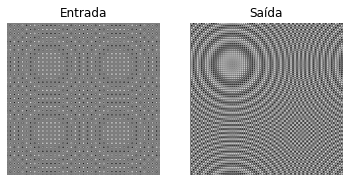

In [6]:
plot_img_in_out(img, img_out)

### Redução aplicando filtro de média na etapa de pré processamento

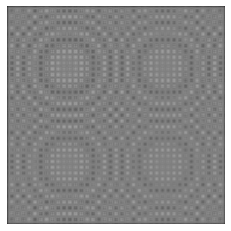

In [14]:
img_pre = spatial_conv(img, lambda x: np.mean(x), kernel_size=9, padding=True)

img_out_mean = np.empty((int(img.shape[0]/2), int(img.shape[1]/2)))

for r in range(img_out_mean.shape[0]):
    for c in range(img_out_mean.shape[1]):
        img_out_mean[r, c] = img_pre[int(2*r), int(2*c)]

plot_img(img_out_mean)

### Comparação

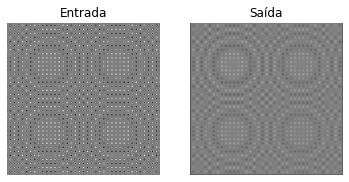

In [15]:
plot_img_in_out(img, img_out_mean)

### Comparação entre imagem de entrada, reduzida usando filtro e reduzida sem usar filtro

(-0.5, 299.5, 299.5, -0.5)

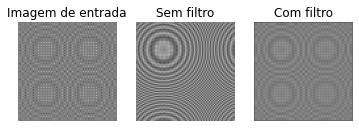

In [16]:
fig, axs = plt.subplots(1, 3)
# input image
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Imagem de entrada')
axs[0].axis('off')
# input image
axs[1].imshow(img_out, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Sem filtro')
axs[1].axis('off')
# output image
axs[2].imshow(img_out_mean, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Com filtro')
axs[2].axis('off')

## Exercício 6

Faça uma rotina que implemente, no domínio da frequência, um filtro passa baixa de Butterworth de ordem n e frequência de corte D0. Aplique esse filtro com n = 1 sobre a imagem [ex_6.tif](img/ex_6.tif) para dois valores de frequência de corte. Aplique novamente o filtro sobre a mesma imagem e mesmas frequências de corte, mas com n = 8. Comente os resultados.

### Rotina de filtro passa baixas Butterworth

In [5]:
def get_butterworth_filter(x, n, d0):
    # filter
    d = lambda u, v, P, Q: np.sqrt(np.power(u - P/2, 2) + np.power(v - Q/2, 2))
    h = lambda u, v, P, Q: 1 / (1 + np.power(d(u, v, P, Q)/d0, 2*n))
    # arguments
    P, Q = x.shape
    # filter
    filt = np.empty_like(x, dtype=np.double)
    for u in range(P):
        for v in range(Q):
            filt[u, v] = h(u, v, P, Q)
    return filt

### Imagem de entrada

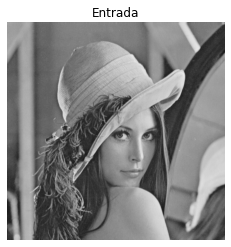

In [6]:
# open image
img = image.imread('img/ex_6.tif')

# transforms
# normalization
img = img / 255

# plot
plot_img(img, 'Entrada')

### Espectro

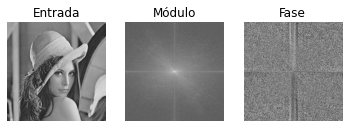

In [7]:
plot_spectrum(img)

### Aplicando filtro para n = 1 e d0 = 25

In [8]:
# shifted fft2 of image in polar coordinates
img_fft2_abs, img_fft2_angle = fft2_polar(img)
# get filter
butterworth_filt_n1 = get_butterworth_filter(img_fft2_abs, 1, 25)
# apply filter
filt_img_fft2_abs_n1 = img_fft2_abs * butterworth_filt_n1
# reconstruct
filt_img_n1 = real_ifft2_polar(filt_img_fft2_abs_n1, img_fft2_angle)

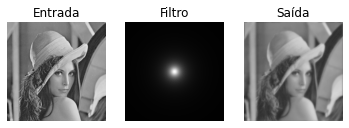

In [9]:
# plots
fig, axs = plt.subplots(1, 3)
# input image
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Entrada')
axs[0].axis('off')
# filter
axs[1].imshow(butterworth_filt_n1, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Filtro')
axs[1].axis('off')
# output image
axs[2].imshow(filt_img_n1, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Saída')
axs[2].axis('off');

### Comparando espectros

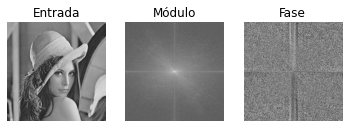

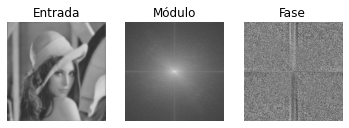

In [10]:
plot_spectrum(img)
plot_spectrum(filt_img_n1)

### Aplicando filtro para n = 8 e d0 = 25

In [11]:
# get filter
butterworth_filt_n8 = get_butterworth_filter(img_fft2_abs, 8, 25)
# apply filter
filt_img_fft2_abs_n8 = img_fft2_abs * butterworth_filt_n8
# reconstruct
filt_img_n8 = real_ifft2_polar(filt_img_fft2_abs_n8, img_fft2_angle)

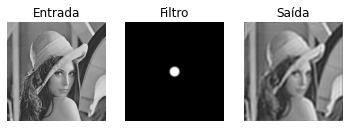

In [12]:
# plots
fig, axs = plt.subplots(1, 3)
# input image
axs[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Entrada')
axs[0].axis('off')
# filter
axs[1].imshow(butterworth_filt_n8, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Filtro')
axs[1].axis('off')
# output image
axs[2].imshow(filt_img_n8, cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Saída')
axs[2].axis('off');

### Comparando espectros

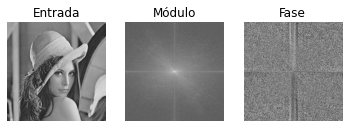

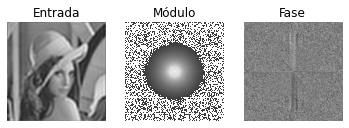

In [13]:
plot_spectrum(img)
plot_spectrum(filt_img_n8)

### Comparando resultados

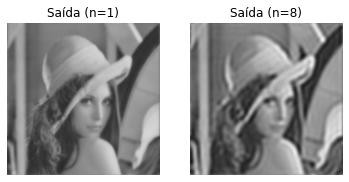

In [15]:
# plots
fig, axs = plt.subplots(1, 2)
# input image
axs[0].imshow(filt_img_n1, cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Saída (n=1)')
axs[0].axis('off')
# filter
axs[1].imshow(filt_img_n8, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Saída (n=8)')
axs[1].axis('off');

## Exercício 7

Observar que a fase da transformada de Fourier contém muita informação sobre a imagem. Para isto, tome as imagens [ex_7_0.tif](img/ex_7_0.tif) e [ex_7_1.tiff](img/ex_7_1.tiff), obtenha suas transformadas, troque a componente de fase de cada uma delas e obtenha as inversas. Avalie os resultados.

### Imagens de entrada

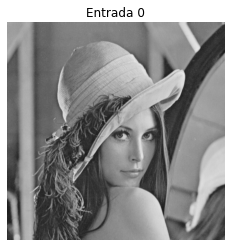

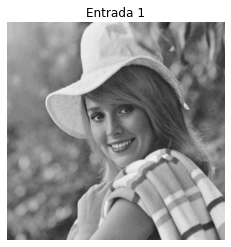

In [19]:
# open images
img_0 = image.imread('img/ex_7_0.tif')
img_1 = image.imread('img/ex_7_1.tiff')

# transforms
# normalization
img_0 = img_0 / 255
img_1 = img_1 / 255

# plot
plot_img(img_0, 'Entrada 0')
plot_img(img_1, 'Entrada 1')

### Trocando fases da DFT

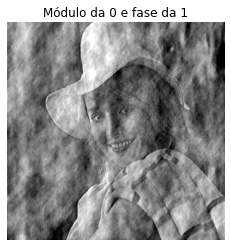

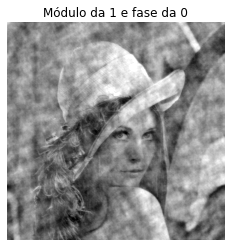

In [21]:
img_0_fft_abs, img_0_fft_angle = fft2_polar(img_0)
img_1_fft_abs, img_1_fft_angle = fft2_polar(img_1)

img_abs_0_angle_1 = real_ifft2_polar(img_0_fft_abs, img_1_fft_angle)
img_abs_1_angle_0 = real_ifft2_polar(img_1_fft_abs, img_0_fft_angle)

plot_img(img_abs_0_angle_1, 'Módulo da 0 e fase da 1')
plot_img(img_abs_1_angle_0, 'Módulo da 1 e fase da 0')

## Exercício 8

Para as imagens [ex_8_0.tif](img/ex_8_0.tif) e [ex_8_1.tif](img/ex_8_1.tif), aplique os filtros média 5x5, mediana 5x5 e filtro adaptativo de mediana, com tamanho máximo 7x7, para tratar o ruído. Compare com a imagem [ex_8_gt.tif](img/ex_8_gt.tif) calculando-se a PSNR (Peak Signal to Noise Ratio) segundo a equação:

![alt text](img/ex_8_p_0.png)

onde

![alt text](img/ex_8_p_1.png)

I(i,j) e K(i.j) são as imagens originais e as ruidosas, respectivamente, e MAX é o maior valor de nível de cinza, sendo = 255. Usar log10 para calcular a PSNR. Compare os resultados e discuta.

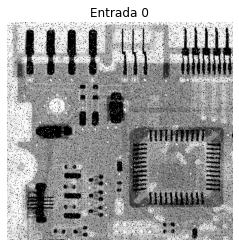

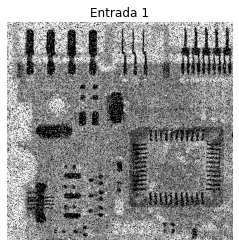

In [60]:
# open images
img_0 = image.imread('img/ex_8_0.tif')
img_1 = image.imread('img/ex_8_1.tif')

# transforms
# normalization
img_0 = img_0 / 255
img_1 = img_1 / 255

# plot
plot_img(img_0, 'Entrada 0')
plot_img(img_1, 'Entrada 1')

### Filtro de média 5x5

#### Entrada 0

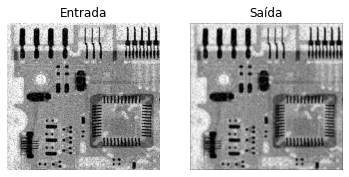

In [61]:
out_img_0_case_0 = spatial_conv(img_0, lambda x: np.mean(x), kernel_size=5, padding=True)
plot_img_in_out(img_0, out_img_0_case_0)

#### Entrada 1

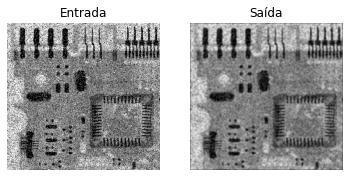

In [62]:
out_img_1_case_0 = spatial_conv(img_1, lambda x: np.mean(x), kernel_size=5, padding=True)
plot_img_in_out(img_1, out_img_1_case_0)

### Filtro de mediana 5x5

#### Entrada 0

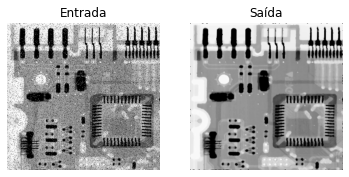

In [63]:
out_img_0_case_1 = spatial_conv(img_0, lambda x: np.median(x), kernel_size=5, padding=True)
plot_img_in_out(img_0, out_img_0_case_1)

#### Entrada 1

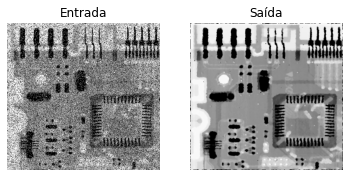

In [64]:
out_img_1_case_1 = spatial_conv(img_1, lambda x: np.median(x), kernel_size=5, padding=True)
plot_img_in_out(img_1, out_img_1_case_1)

 ### Filtro adaptativo de mediana 7x7

In [65]:
def adaptive_median_filter(a, max_k_size=7):
    # returns single adaptive filterer value
    def filter_k(k):
        # max kernek offset (also central index of kernel)
        s_max = int((max_k_size - 1)/2)
        # initial kernek offset (adaptive)
        s = 1
        # central value
        z_xy = k[s_max, s_max]
        # get value
        while True:
            # case a
            s_xy = k[s_max-s:s_max+s+1, s_max-s:s_max+s+1]
            z_min = np.min(s_xy)
            z_max = np.max(s_xy)
            z_med = np.median(s_xy)
            a_1 = z_med - z_min
            a_2 = z_med - z_max
            if a_1 > 0 and a_2 < 0:
                # case b
                b_1 = z_xy - z_min
                b_2 = z_xy - z_max
                return z_xy if b_1 > 0 and b_2 < 0 else z_med
            else:
                s = s + 1
                if s <= s_max:
                    continue
                return z_med
    # max neighborhood range of kernel along each axis, considering a central pixel and without conting it
    max_k_offset = int((max_k_size - 1) / 2)
    # padded input
    a_in = np.pad(a, max_k_offset)
    # initialize output
    b_out_shape = (a_in.shape[0] - max_k_size + 1, a_in.shape[1] - max_k_size + 1)
    b_out = np.empty(b_out_shape, dtype=a_in.dtype)
    # iterate over rows and coluns
    for r_out, r_in in enumerate(range(max_k_offset, a_in.shape[0] - max_k_offset)):
        for c_out, c_in in enumerate(range(max_k_offset, a_in.shape[1] - max_k_offset)):
            # kernel as neighborhood of input
            k = a_in[r_in-max_k_offset:r_in+max_k_offset+1, c_in-max_k_offset:c_in+max_k_offset+1]
            # apply adaptive filter
            b_out[r_out, c_out] = filter_k(k)
    return b_out

#### Entrada 0

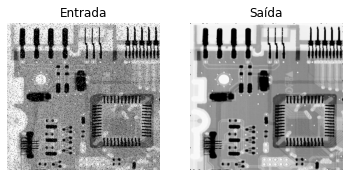

In [66]:
out_img_0_case_2 = adaptive_median_filter(img_0, max_k_size=7)
plot_img_in_out(img_0, out_img_0_case_2)

#### Entrada 1

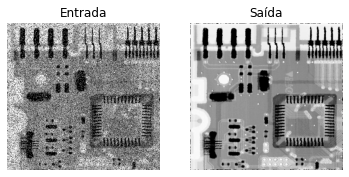

In [67]:
out_img_1_case_2 = adaptive_median_filter(img_1, max_k_size=7)
plot_img_in_out(img_1, out_img_1_case_2)

### Comparação (PSNR)

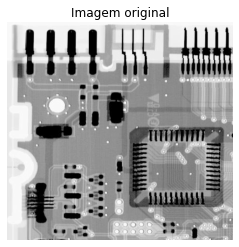

In [68]:
# ground truth
img_gt = image.imread('img/ex_8_gt.tif')
img_gt = np.dot(img_gt, [1/3, 1/3, 1/3, 0])

# transforms
# normalization
img_gt = img_gt / 255

# plot
plot_img(img_gt, 'Imagem original')

In [69]:
# Peak Signal to Noise Ratio
def psnr(x, gt):
    mse = np.sum(np.power(gt - x, 2))/x.size
    return 10*np.log10(1/mse)

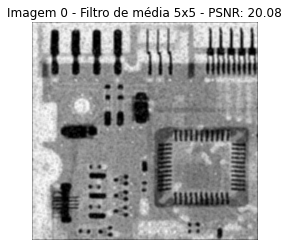

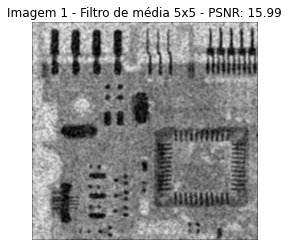

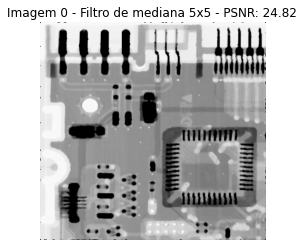

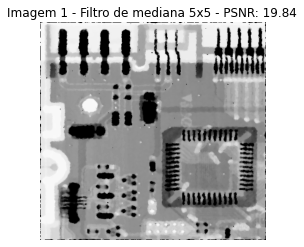

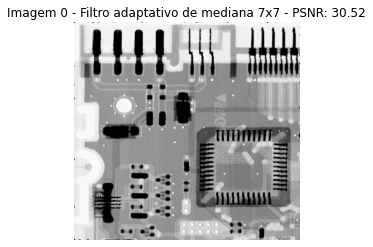

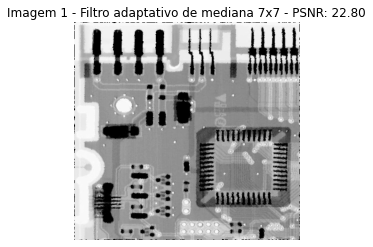

In [70]:
out_imgs = [(out_img_0_case_0, 'Imagem 0 - Filtro de média 5x5 - PSNR: '),
            (out_img_1_case_0, 'Imagem 1 - Filtro de média 5x5 - PSNR: '),
            (out_img_0_case_1, 'Imagem 0 - Filtro de mediana 5x5 - PSNR: '),
            (out_img_1_case_1, 'Imagem 1 - Filtro de mediana 5x5 - PSNR: '),
            (out_img_0_case_2, 'Imagem 0 - Filtro adaptativo de mediana 7x7 - PSNR: '),
            (out_img_1_case_2, 'Imagem 1 - Filtro adaptativo de mediana 7x7 - PSNR: '),]

for out_img, title in out_imgs:
    plot_img(out_img, title + '{:.2f}'.format(psnr(out_img, img_gt)))

## Perguntas

### 1) Explique como é o procedimento de amostragem e quantização de uma imagem. Explique os problemas relacionados com a resolução espacial e de intensidade.

Uma imagem é uma projeção bidimensional, de um espaço tridimensional, que para sua representação em formato digital necessita ser discretizada espacialmente pelo processo de amostragem. Este processo resulta em uma função cujo domínio espacial é discretizado, que é adequado para armazenamento em sistemas digitais.

Também devido à necessidade de representação em sistemas digitais, os valores de itensidade de luz ao longo do espaço também devem ser armazenados num domínio discreto pelo processo de quantização.

A amostragem limita a capacidade de representação espacial da imagem, onde altos valores de frequências espaciais podem não ser devidamente representados. Este resultado é provado pelo teorema de Nyquist.

De forma similar, a quantização limita a capacidade de representação de valores de intensidade (e cores), que é um efeito mais notável quando se há poucos níveis de intensidade disponíveis. Um sintoma desse problema que é mais paupável é o aparecimento de faixas de intensidades em gradientes usando níveis de intensidades mais escuros, principalmente utilizando-se só tons escuros de cinza com valores muito próximos.

### 2) Explique o procedimento para ampliar uma imagem N1 x M1 para uma imagem N2 x M2 (N2 > N1, M2 > M1). Quais são os métodos para estimar os valores de pixels desconhecidos?

Uma técnica que pode ser utilizada é a interpolação, onde valores intensidades ou cores desconhecidas da imagem ampliada são dados em função de uma vizinhança de pixeis da imagem de entrada que é calculado em função das coordenadas do pixel analisado.

Nesta técnica é possível determinar o valore de um pixel desconhecido pela uso do valor do pixel do vizinho mais próximo, ou aplicando uma interpolação bi-linear, ou uma interpolação bi-cúbica, dentre outras abordagens possíveis.

### 3) Como você explicaria frequência espacial em uma imagem?

Frequência é um termo mais associado a sinais cujo domínio é o tempo, mas sua noção pode ser perfeitamente extendida para sinais cujo domínio é espacial. Neste caso, pode-se analisar o sinal a partir da série de Fourier dele, onde é possível ver suas componentes oscilatórias, sendo que a cada uma destas componentes uma frequência é associada a ela.

O termo frequência espacial pode ser usado para se referir a componente principal desta decomposição, ou seja, a componente de maior oscilatória coeficiente na série de Fourier.

### 4) Qual é o procedimento a ser realizado (sequência de etapas) se quisermos realizar uma filtragem no domínio espacial? Imagine, por exemplo, uma imagem de 512x512 e queremos filtrá-la usando uma máscara de dimensões 3x3, qual seria o procedimento?

Opicinalmente, pode-se adicionar um padding de largura 1 (para máscara 3x3) à imagem de entrada para preservar suas dimenssões na saída e atribuir valores de intensidade a estes pixeis conforme a técnica desejada, como por exemplo atribuir valores 0 a estes pixeis. Depois disso, percorre-se a imagem com a máscara, estando a máscara completamente inserida nela, e para cada posisão computa-se através de uma função de redução o valor correspondente a um pixel da saída.

### 5) Se não for feito o preenchimento de zeros na borda da imagem, qual será o resultado (saída) de uma imagem filtrada no domínio do espaço por um filtro de média de mesmas dimensões da imagem? Explique a sua resposta.

A saída de uma filtragem espacial é, por consequência de sua definição, uma imagem de dimensões menores que a imagem original. Se na etapa de pré-processamento não for adicionado um padding na imagem de entrada, o resultado da operação será uma imagem de dimensões menores que a imagem entrada (previamente ao pré-processamento). Isso é consequência da máscara de filtragem espacial não conseguir centralizar todos os pixeis da entrada (para máscaras `NxN`, onde `N` é ímpar, que é o caso para filtros espaciais). Para evitar essa redução, é necessário adicionar à entrada um padding de largura `(N-1)/2`.

Baseado na explicação no início do exercício 4, onde as dimensões de uma filtragem espacial é derivada em analogia à operação de convolução matriz-matriz, concluímos que, se não for feito o preenchimento de zeros na borda da imagem, o resultado de uma imagem filtrada no domínio do espaço por um filtro de média de mesmas dimensões da imagem é uma matriz `1x1` cujo valor é a média da imagem. A imagem de saída é uma matriz `ExF` onde:

- `E = A - C + 1`
- `F = B - D + 1`

sendo `A = C` a altura da imagem/filtro e `B = D` a largura da imagem/filtro. Resultando em:

- `E = 1`
- `F = 1`

### 6) Qual é a diferença entre os termos DFT e DTFT? Explique/Comente suas implicações.

DFT é a transformada discreta de Fourier, que é aplicada a sinais discretos e periódicos, resultando em um sinal, denominado espectro, que também é discreto e periódico.

DTFT é a transformada de Fourier de tempo discreto, que é aplicada a sinais discretos e aperiódicos, resultando em um sinal que é contínuo e periódico.

Em processamentos de sinais utilizando-se computadores digitais, não é possível se representar um sinal contínuo. Consequentemente, se quisermos trabalhar com sinais aperiódicos, não seria possível aplicar a DTFT nele e armazenar seu resultado em um sistema digital. Uma solução para remediar tal problema é fazer considerações para tornar o sinal periódico a fim de se usar a DFT no lugar da DTFT, já que seu resultado é possível ser armazenado em um sistema digital.

### 7) Comente três formas possíveis para estimar a função de degradação em uma imagem degradada.